<a href="https://colab.research.google.com/github/rahulroynit/Iterative-Imputer/blob/master/Iterative_Imputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler 
import warnings

In [2]:
# drop warnings during run-time
warnings.filterwarnings(action = 'ignore')

In [3]:
# load data
X, y = fetch_california_housing(return_X_y=True)
print(type(X), type(y), X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (20640, 8) (20640,)


In [4]:
# reshape y into 1-D array
y = y.reshape((-1, 1))
print(y.shape)

(20640, 1)


In [5]:
# query data
print(pd.DataFrame(X).info(), pd.DataFrame(y).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20640 non-null  float64
 1   1       20640 non-null  float64
 2   2       20640 non-null  float64
 3   3       20640 non-null  float64
 4   4       20640 non-null  float64
 5   5       20640 non-null  float64
 6   6       20640 non-null  float64
 7   7       20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20640 non-null  float64
dtypes: float64(1)
memory usage: 161.4 KB
None None


In [6]:
# check data
print(pd.DataFrame(X).head())

        0     1         2         3       4         5      6       7
0  8.3252  41.0  6.984127  1.023810   322.0  2.555556  37.88 -122.23
1  8.3014  21.0  6.238137  0.971880  2401.0  2.109842  37.86 -122.22
2  7.2574  52.0  8.288136  1.073446   496.0  2.802260  37.85 -122.24
3  5.6431  52.0  5.817352  1.073059   558.0  2.547945  37.85 -122.25
4  3.8462  52.0  6.281853  1.081081   565.0  2.181467  37.85 -122.25


In [7]:
# create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16512, 8) (16512, 1) (4128, 8) (4128, 1)


In [8]:
# cv performance on complete data
def cv_score_complete_data(X_train, y_train):
  # create cv object
  cv_comp = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2020)
  # create pipeline
  pipe_comp = Pipeline(steps = [('minmax', MinMaxScaler()), ('xtrees', ExtraTreesRegressor())])
  # cv score
  cv_score_comp = cross_val_score(pipe_comp, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = cv_comp)
  # print mean and std of cv score
  print('CV score (RMSE) on complete data')
  print(f'mean cv score = {-1*np.mean(cv_score_comp)} \nstd cv score = {np.std(cv_score_comp)}')
  return cv_score_comp

In [9]:
# check cv performance on complete data
cv_comp = cv_score_complete_data(X_train, y_train)

CV score (RMSE) on complete data
mean cv score = 0.5039324395260599 
std cv score = 0.011052019501703408


In [10]:
# create a copy of X_train as a dataframe and add missing values to it 
X_missing = pd.DataFrame(X_train.copy())
print(X_missing.shape)

(16512, 8)


In [11]:
# insert n missing values
n = 2000
for column in X_missing.columns:
  rand_idx = np.random.choice(X_missing.shape[0], size = n, replace = False)
  X_missing.iloc[rand_idx, column] = np.nan

In [12]:
# count of missing values
print(X_missing.isna().sum())

0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
7    2000
dtype: int64


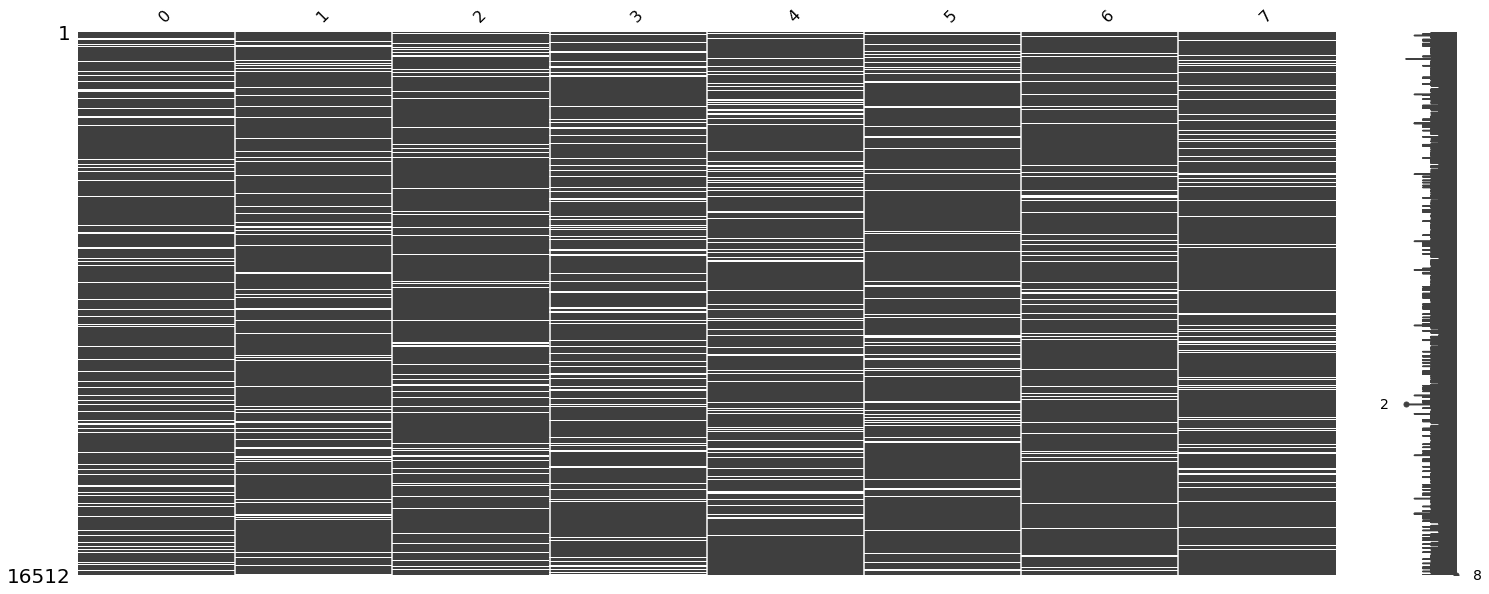

In [13]:
# visualize missing data
import missingno as msno
msno.matrix(X_missing)

In [14]:
# array of missing data X
X_train_missing = np.array(X_missing)
print(X_train_missing.shape)

(16512, 8)


In [15]:
# cv performance on imputed data with no missing data indicator
def cv_score_missing_data(X_train_missing, y_train):
  # creta cv object
  cv_impute = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2020)
  # create pipeline
  pipe_impute = Pipeline(steps = [('imputer', IterativeImputer(estimator = BayesianRidge())), ('minmax', MinMaxScaler()),
                                  ('xtrees', ExtraTreesRegressor())])
  # cv score
  cv_score_impute = cross_val_score(pipe_impute, X_missing, y_train, scoring = 'neg_root_mean_squared_error', cv = cv_impute)
  # print mean and std of cv score
  print('CV score (RMSE) on imputed data with no missing data indicator')
  print(f'mean cv score = {-1*np.mean(cv_score_impute)} \nstd cv score = {np.std(cv_score_impute)}')
  return cv_score_impute

In [16]:
# check cv performance on missing data with no indicator
cv_impute = cv_score_missing_data(X_train_missing, y_train)

CV score (RMSE) on imputed data with no missing data indicator
mean cv score = 0.5766163182542637 
std cv score = 0.012654539973048988


In [17]:
# cv performance on imputed data with missing data indicator
def cv_score_missing_data_indicator(X_train_missing, y_train):
  # creta cv object
  cv_impute = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2020)
  # create pipeline
  pipe_impute = Pipeline(steps = [('imputer', IterativeImputer(estimator = BayesianRidge(), add_indicator = True)), 
                                  ('minmax', MinMaxScaler()), ('xtrees', ExtraTreesRegressor())])
  # cv score
  cv_score_impute = cross_val_score(pipe_impute, X_missing, y_train, scoring = 'neg_root_mean_squared_error', cv = cv_impute)
  # print mean and std of cv score
  print('CV score (RMSE) on imputed data with missing data indicator')
  print(f'mean cv score = {-1*np.mean(cv_score_impute)} \nstd cv score = {np.std(cv_score_impute)}')
  return cv_score_impute

In [18]:
# check cv performance on missing data with no indicator
cv_impute_indicator = cv_score_missing_data_indicator(X_train_missing, y_train)

CV score (RMSE) on imputed data with missing data indicator
mean cv score = 0.5702905323062278 
std cv score = 0.012372402944412263


In [21]:
# cv keys and values
keys = ["cv_complete", "cv_imputed", "cv_imputed_indicator"]
vals = [-1*np.mean(cv_comp), -1*np.mean(cv_impute), -1*np.mean(cv_impute_indicator)]

<BarContainer object of 3 artists>

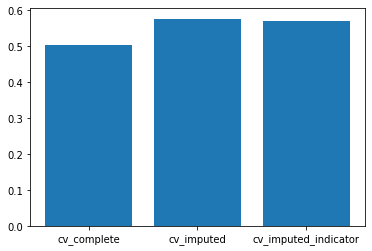

In [22]:
# plot the cv performance
plt.bar(keys, vals)